In [1]:
import numpy as np
import pandas as pd
import csv
import json
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

In [13]:
dataframe = pd.read_excel('F:\ChadBot\data\meteo.xls')
dataframe.set_index('Ora locală în Ploieşti')

,T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
Ora locală în Ploieşti,,,,,,,,,,,,,,,,,,,,,
21.09.2021 19:00,15.9,749.9,765.9,-0.5,62,Vânt din direcţia vest,3.0,NaN,NaN,70 – 80%.,...,Altocumulus cumulogenitus (sau Altocumulus cum...,Cirrus spissatus cumulonimbogenitus.,10,8.6,NaN,NaN,NaN,NaN,NaN,NaN
21.09.2021 18:00,16.2,749.8,765.7,-0.9,61,Vânt din direcţia vest-sud-vest,2.0,NaN,NaN,90 sau mai mult insa nu 100%,...,Altocumulus cumulogenitus (sau Altocumulus cum...,Cirrus spissatus cumulonimbogenitus.,10,8.7,NaN,NaN,NaN,NaN,NaN,NaN
21.09.2021 17:00,17.4,749.8,765.7,-1.1,56,Vânt din direcţia vest-sud-vest,2.0,NaN,NaN,70 – 80%.,...,Altocumulus cumulogenitus (sau Altocumulus cum...,Cirrus spissatus cumulonimbogenitus.,10,8.4,NaN,NaN,NaN,NaN,NaN,NaN
21.09.2021 16:00,17.3,750.4,766.2,-0.6,59,Vânt din direcţia vest-sud-vest,3.0,NaN,NaN,60%.,...,"Fără nori Alocumulus, Altostratus sau Nimbostr...",Cirrus spissatus cumulonimbogenitus.,10,9.2,NaN,NaN,NaN,NaN,NaN,NaN
21.09.2021 15:00,15.6,750.7,766.6,-0.2,66,Vânt din direcţia vest-sud-vest,2.0,NaN,NaN,70 – 80%.,...,"Fără nori Alocumulus, Altostratus sau Nimbostr...","Fără nori Cirrus, Cirrocumulus sau Cirrostratus.",10,9.2,Precipitaţii nu sunt,6.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21.09.2020 04:00,11.9,750.4,766.5,0.2,67,Vânt din direcţia nord-nord-est,2.0,NaN,NaN,fără nori,...,NaN,NaN,10,5.9,NaN,NaN,NaN,NaN,NaN,NaN
21.09.2020 03:00,11.7,750.5,766.7,0.5,69,Vânt din direcţia nord-est,1.0,NaN,NaN,fără nori,...,NaN,NaN,10,6.2,Precipitaţii nu sunt,6.0,NaN,NaN,NaN,NaN
21.09.2020 02:00,12.8,750.2,766.3,0.4,64,Vânt din direcţia nord-nord-est,1.0,NaN,NaN,fără nori,...,NaN,NaN,10,6.0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
def model_lstm(look_back):
        tf.keras.backend.clear_session()
        tf.random.set_seed(51)
        np.random.seed(51)
        model=tf.keras.Sequential()
        model.add(keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]))
        model.add(LSTM(200, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
        return model

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
        dataset = tf.data.Dataset.from_tensor_slices(series)
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
        dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
        dataset = dataset.batch(batch_size).prefetch(1)
        return dataset

In [17]:
temp = list(dataframe['T'])

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="model/temp",
        save_best_only=True, 
        monitor="mae",
        verbose=0,
    )
]

time = np.arange(len(temp) + 1, dtype="float32")
split_time = int(len(temp)/3)
time_train = time[:2*split_time]
x_train = temp[:2*split_time]
time_valid = time[split_time*2:]
x_valid = temp[split_time*2:]
window_size = 7
batch_size = 32
shuffle_buffer_size = 1500

print(len(x_train), len(x_valid), split_time)
dataset = windowed_dataset(x_train, window_size, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model=model_lstm(window_size)
history = model.fit(dataset, epochs=200, batch_size=32,verbose=1, callbacks=[callbacks])

5848 2925 2924
Epoch 1/200
     88/Unknown - 1s 13ms/step - loss: 44.5843 - mse: 44.5843 - mae: 4.2348INFO:tensorflow:Assets written to: model\temp\assets
92/92 [==============================] - 3s 36ms/step - loss: 43.1770 - mse: 43.1770 - mae: 4.1404
Epoch 2/200
92/92 [==============================] - 5s 51ms/step - loss: 3.0614 - mse: 3.0614 - mae: 1.3219
Epoch 3/200
92/92 [==============================] - 5s 54ms/step - loss: 2.0844 - mse: 2.0844 - mae: 1.0670
Epoch 4/200
92/92 [==============================] - 5s 52ms/step - loss: 1.8788 - mse: 1.8788 - mae: 1.0006
Epoch 5/200
92/92 [==============================] - 4s 48ms/step - loss: 1.8292 - mse: 1.8292 - mae: 0.9847
Epoch 6/200
92/92 [==============================] - 2s 17ms/step - loss: 1.9242 - mse: 1.9242 - mae: 1.0246
Epoch 7/200
92/92 [==============================] - 4s 45ms/step - loss: 1.7785 - mse: 1.7785 - mae: 0.9629
Epoch 8/200
92/92 [==============================] - 1s 13ms/step - loss: 1.8265 - mse: 1.82

In [36]:
model = tf.keras.models.load_model('model/temp')
model.summary()

forecast=[]
for time in range(len(temp) - window_size):
    forecast.append(model.predict(np.array(temp[time:time + window_size]).reshape(1,7)))
results = np.array(forecast)[:, 0, 0]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


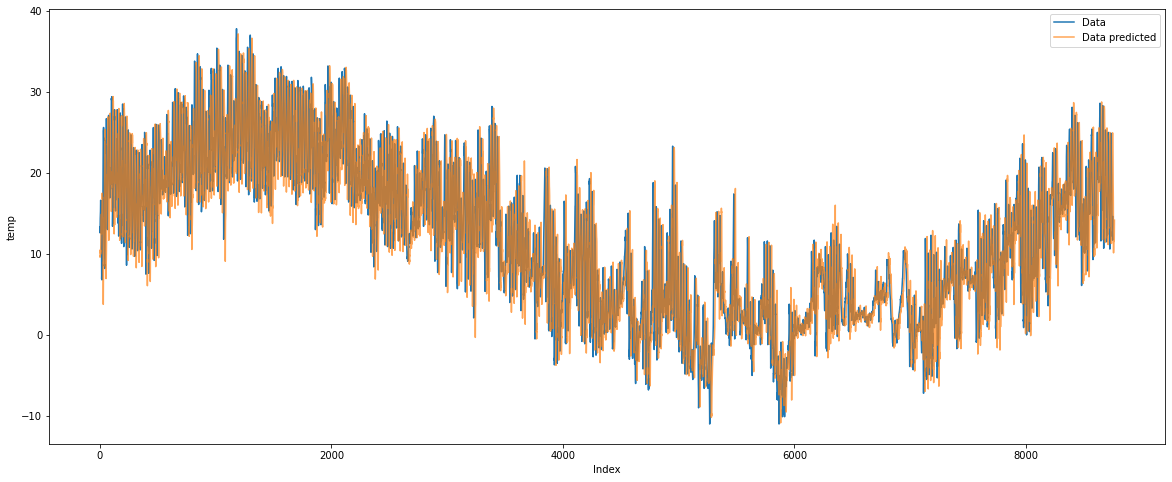

In [37]:
plt.figure(figsize=(20,8))
plt.plot(temp[20:], label='Data')
plt.plot(results, label='Data predicted', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('temp')
plt.legend()
plt.savefig('model/temp.jpg')